# Simulation
---
---
---

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Import the data

In [2]:
# Set the time span
start_date = '2000-01-01'
end_date = '2018-01-01'

# If there is no data provided you ca download it using commented part below
'''
import pandas_datareader as pdr

df_to_save = pdr.DataReader(name='AAPL', data_source='yahoo', start=start_date, end=end_date)
df_to_save.head(5)

df_to_save.to_csv('AAPL_YAHOO.csv')

'''

# Make sure that the data is in the same folder and has specific name
# Once the data is downloaded you can run just below line to import the data in
df = pd.read_csv('AAPL_YAHOO.csv', index_col='Date', parse_dates=True)


# Pick only needed values
df_close = df[['Close']].copy()
df_close.head(2)

,Close
Date,
2000-01-03,3.997768
2000-01-04,3.660714


## Prepare the datasets

In [3]:
# Train set # 4400 sessions
train = df_close.iloc[:4400] # pandas.core.series.Series (4500,) **
train_index = train.index # pandas.core.indexes.datetimes.DatetimeIndex

# Test set # 128 sessions
test = df_close.iloc[4400:] # pandas.core.series.Series (128,) **
test_index = test.index # pandas.core.indexes.datetimes.DatetimeIndex



######################################################################

from sklearn.preprocessing import MinMaxScaler 

# From Pandas TimeSeries into NumPy array
# Train
train = train.values # numpy.ndarray (4400,)
train = train.reshape((len(train), 1)) # numpy.ndarray (4400, 1)

# Test
test = test.values # numpy.ndarray (128,)
test = test.reshape((len(test), 1)) # numpy.ndarray (128, 1)


# Fit the train data only. You don't want to provide any clue about test set condition.
scaler = MinMaxScaler()
scaler.fit(train)


# Transform the data then export to Pandas TimeSeries as began
# Train
train_norm = scaler.transform(train) # numpy.ndarray (4400, 1)
train_norm = train_norm.tolist() # list of single value lists [[x], [y], [z]]
train_norm = np.squeeze(train_norm) # numpy.ndarray array([x, y, z])
train_norm = pd.Series(train_norm, train_index) # pandas.core.series.Series (4500,) **

# Test
test_norm = scaler.transform(test) # numpy.ndarray (128, 1)
test_norm = test_norm.tolist() # list of single value lists [[x], [y], [z]]
test_norm = np.squeeze(test_norm) # numpy.ndarray array([x, y, z])
test_norm = pd.Series(test_norm, test_index) # pandas.core.series.Series (128,) **

## Import prepared csv file with models details

In [4]:
data = pd.read_csv('activation_function_csv.csv', sep=';', encoding='utf-8', index_col='index')
data.dropna(inplace=True)
data.head(2)

,optimizer,path,folder_name,model_name,loss_history,generator,hidden_layers,neurons
index,,,,,,,,
0,sgd,/Users/patryklaskowski/Desktop/ANN_for_Apple_s...,MODEL1-relu-relu-linear-sgd/,my_MODEL1-relu-relu-linear-sgd_gen0.h5,my_MODEL1-relu-relu-linear-sgd_gen_LOSS0.csv,1,2,20
1,sgd,/Users/patryklaskowski/Desktop/ANN_for_Apple_s...,MODEL1-relu-relu-linear-sgd/,my_MODEL1-relu-relu-linear-sgd_gen1.h5,my_MODEL1-relu-relu-linear-sgd_gen_LOSS1.csv,1,2,20


In [5]:
# Prepare variables to make work easier
columns = list(data.columns)

path = 'path'
model_name = 'model_name'
loss_history = 'loss_history'
folder_name = 'folder_name'

## Import models from the csv file

In [6]:
# Library import
from keras.models import load_model



# Create names for all created models using pattern 'model_x_y',-
# - where x stands for model number and y for iteration  
NAMES = []
i = 1
j = 1

for _ in range(len(data)):
    NAMES.append('model_' + str(i) + '_' + str(j))       
    if j%3 == 0:
        i += 1
        j = 0    
    j += 1
    
    

# Create dictionary with models names as a key and its Keras equivalent with loss history based on MSE
# full_model_path = folder_path + folder_name + model_name
MODELS = {}
for i in range(len(data)):
    model = load_model(data.iloc[i][path] + data.iloc[i][folder_name] + data.iloc[i][model_name])
    model_loss = pd.read_csv(data.iloc[i][path] + data.iloc[i][folder_name] + data.iloc[i][loss_history],
                             index_col='Unnamed: 0')
    
    #print(NAMES[i], " imported" , end="\n")
    MODELS[NAMES[i]] = [model, model_loss]

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


---
# Now this is the time when simulation starts for real
---

## 'model_1_1' is the best chosen model among the others that were analysed:
- simulation based on few assumptions:
    - programm starts with $10 000
    - always buy/sell 10 actions per transaction
    - if predicted value for is expected higher than todays, then buy otherwise don't
    - to cash the profit sell the batch you bought day earlier
    - marekt price chages just once a day

--------------------------------------------------model_1_1-------
	START DATE: 2017-06-28 00:00:00.

	1) Wallet: $10000,
	2) buy 10 assets always and only -
	   while the predicted price chage is going to increase,
	3) assets owned: 0.

	STOP DATE: 2017-10-09 00:00:00.

	4) After 70 days, wallet change equals $118.40.
	5) Wallet afterall: $10118.40
	6) Assets left: 0.
------------------------------------------------------------------
	Accuracy over 70 days of trading equals 48.57%  (34/70)
------------------------------------------------------------------



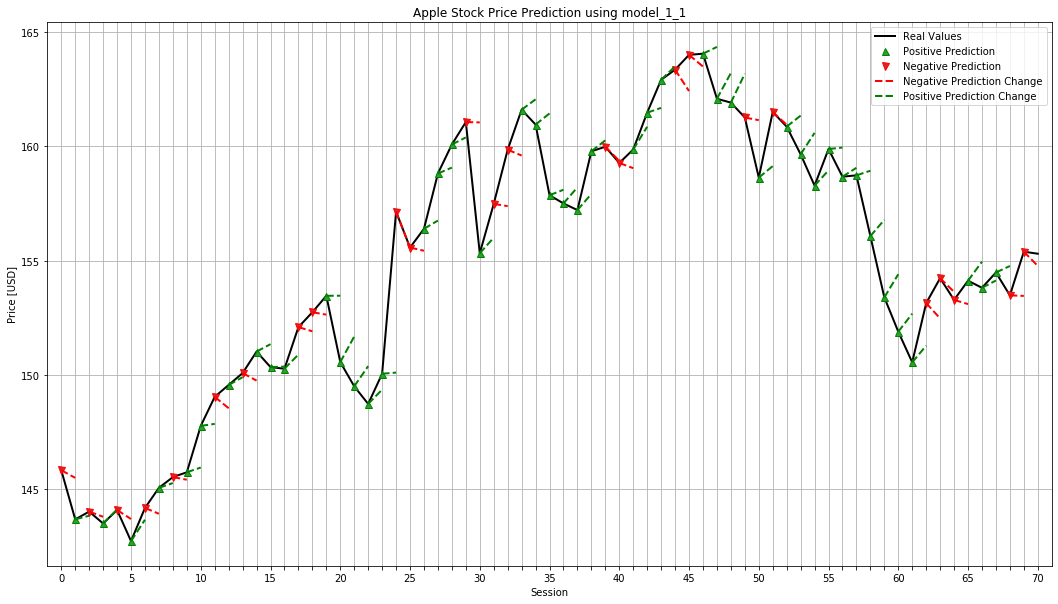

In [7]:
n_input = 20 #Same as generator length

##########################################
##########################################
##########################################
##########################################

model = MODELS['model_1_1'][0]

n_days = 70 # How many days you want to trade

start = train_norm[-1:].index
stop = test_norm[n_days:n_days+1].index

##########################################
##########################################
##########################################
##########################################

decision_predicted = []
decision_real = []

##########################################

will_increase = []
will_decrease = []

##########################################

predictions_all = []
real_prices = []

##########################################

wallet_start = 10000 # Wllet value $$
wallet = wallet_start
n_assets = 10 # How many asstes to buy every transaction
assets_total = 0 # How many asstes do you have
assets_bought = 0

##########################################

first_batch = train_norm[-n_input:].values.reshape((1, n_input)) # Normalised

today_price_norm = train_norm[-1:].values # Normalised
today_price = scaler.inverse_transform([today_price_norm]).squeeze()

##########################################
# For plotting purposes
todays = []
todays.append(today_price)
##########################################
# Real prices cumulator
real_prices.append(today_price)

print(f'\
--------------------------------------------------model_1_1-------\n\
\tSTART DATE: {str(list(start)[0])}.\n\n\
\t1) Wallet: ${wallet},\n\
\t2) buy {n_assets} assets always and only -\n\
\t   while the predicted price chage is going to increase,\n\
\t3) assets owned: {assets_total}.\n')

for day in range(n_days):
    #print(f'\nDAY {day}: ')
    prediction_norm = model.predict(first_batch).squeeze().tolist() # Normalised
    prediction = scaler.inverse_transform([[prediction_norm]]).squeeze()
    
    predictions_all.append(prediction)
    
    
    if prediction > today_price:
        wallet -= today_price * n_assets
        assets_total += n_assets
        decision_predicted.append('up')
        will_increase.append(day)
        
        assets_bought += n_assets
        # DECISION
        
    elif prediction == today_price:
        decision_predicted.append('still')
        # DECISION
        
    elif prediction < today_price:
        decision_predicted.append('down')
        will_decrease.append(day)
        # DECISION
        
    ##########################################
    ###### END OF THE DAY ####################
    
    tomorrow_price_norm = test_norm[day].squeeze() # Normalised
    tomorrow_price = scaler.inverse_transform([[tomorrow_price_norm]]).squeeze()

    # Real prices cumulator
    real_prices.append(tomorrow_price)

    # To be able to compare predicted change with real changes
    if (tomorrow_price - today_price)*100000 > 0:
        decision_real.append('up')
    elif (tomorrow_price - today_price)*100000 == 0:
        decision_real.append('still')
    elif (tomorrow_price - today_price)*100000 < 0:
        decision_real.append('down')

    #########
    # NEW DAY
    today_price_norm = tomorrow_price_norm
    today_price = tomorrow_price
    
    ##
    todays.append(today_price)
    ##
    
    # Realize the profit (Cash the assets)
    if assets_total:
        wallet += today_price * n_assets
        assets_total -= n_assets
    #########
    
    new_batch = np.append(first_batch, today_price_norm)[1:].reshape((1, n_input))
    first_batch = new_batch

    
print(f'\
\tSTOP DATE: {str(list(stop)[0])}.\n\n\
\t4) After {n_days} days, wallet change equals ${wallet - wallet_start:.2f}.\n\
\t5) Wallet afterall: ${wallet:.2f}\n\
\t6) Assets left: {assets_total}.\n\
------------------------------------------------------------------')   

##########################################
##########################################
##########################################
##### ACCURACY ###########################

total = []
for i in range(n_days):
    total.append(decision_real[i] == decision_predicted[i])

acc = (sum(total)/n_days)*100
print(f'\tAccuracy over {n_days} days of trading equals {acc:.2f}%  ({sum(total)}/{n_days})\n\
------------------------------------------------------------------\n')

##########################################
##########################################
##########################################
####### PLOT #############################
will_increase_y = []
for i in will_increase:
    will_increase_y.append(real_prices[i])

will_decrease_y = []
for i in will_decrease:
    will_decrease_y.append(real_prices[i])
#########
plt.figure(figsize=(18, 10))
plt.plot(np.arange(0, len(real_prices)), real_prices,
         lw=2, color='black') # Real
plt.plot(will_increase, will_increase_y,
         marker='^', mfc='tab:green', mec='green', ls='', ms=7) # Increase
plt.plot(will_decrease, will_decrease_y,
         marker='v', mfc='tab:red', mec='red', ls='', ms=7) # Decrease

# Plot --- line of predictions
for ses in range(n_days):
    if ses in will_increase:
        plt.plot([ses, ses+1], [todays[ses], predictions_all[ses]], ls='--', color='green', lw=2)
    else:
        plt.plot([ses, ses+1], [todays[ses], predictions_all[ses]], ls='--', color='red', lw=2)

#########
labels = []
lbls = np.arange(0, n_days+1)
for i in range(n_days+1):
    if i%5==0:
        labels.append(lbls[i])
    else:
        labels.append('')
#########
plt.grid(axis='x')
plt.grid(axis='y')
plt.xticks(np.arange(0, n_days+1), labels=labels)
plt.yticks(np.arange(140, 170, 5))
plt.autoscale(tight=False, axis='both')
plt.xlim(-1, n_days+1)
plt.legend(['Real Values', 'Positive Prediction',
            'Negative Prediction',
            'Negative Prediction Change',
            'Positive Prediction Change'])
plt.xlabel('Session')
plt.ylabel('Price [USD]')
plt.title('Apple Stock Price Prediction using model_1_1')
plt.show()
##########################################
##########################################

# BAM!
## Description:

- plot above provides decisions made based on model's predictions on top of real data
- red triangle stands for 'Don't buy' which means that model predicted price decrease next day
- in opposite green up turned triangles stands for 'Buy' which means that model predicted value increase for the following session.
- the break line shows what kind of change model predicted